##  K-Means

#### imports

In [1]:
import os
import sys
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from pyspark.sql import SparkSession

from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.clustering import KMeans


In [16]:
warnings.filterwarnings('ignore')

SCRIPT_DIR = os.path.abspath('')
sys.path.append(os.path.dirname(SCRIPT_DIR))


#### Get data

In [3]:
from util.file import get_absolute_file_path

relative_path = "../data/iris.csv"
file_path = get_absolute_file_path(relative_path)


In [17]:
spark = SparkSession \
    .builder \
    .appName("K-means") \
    .getOrCreate()


In [5]:
df = spark.read.format('csv') \
    .options(header='true', inferschema='true') \
    .load(file_path)
df.show(5)


+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



In [6]:
df.printSchema()


root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



In [7]:
df.describe().show()


+-------+------------------+-------------------+------------------+------------------+--------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|       species|
+-------+------------------+-------------------+------------------+------------------+--------------+
|  count|               150|                150|               150|               150|           150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|          null|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|          null|
|    min|               4.3|                2.0|               1.0|               0.1|   Iris-setosa|
|    max|               7.9|                4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+-------------------+------------------+------------------+--------------+



#### Convert the data to dense vector (features)

In [8]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])


In [9]:
transformed = transData(df)
transformed.show(5)


+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
+-----------------+
only showing top 5 rows



#### Deal With Categorical Variables

In [10]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features",
                               outputCol="indexedFeatures",
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)
data.show(5, True)


+-----------------+-----------------+
|         features|  indexedFeatures|
+-----------------+-----------------+
|[5.1,3.5,1.4,0.2]|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|
+-----------------+-----------------+
only showing top 5 rows



#### Elbow method to determine the optimal number of clusters for k-means clustering

In [11]:
from pyspark.ml.evaluation import ClusteringEvaluator

cost = np.zeros(20)

evaluator = ClusteringEvaluator()


for k in range(2, 20):
    kmeans = KMeans()\
        .setK(k)\
        .setSeed(1)

    model = kmeans.fit(data)
    predictions = model.transform(data)
    silhouette = evaluator.evaluate(predictions)
    cost[k] = silhouette


#### We can see that the local maximum is at K=3 i.e. 3 clusters will give us the best results (which is also the number of labels in the original dataset).

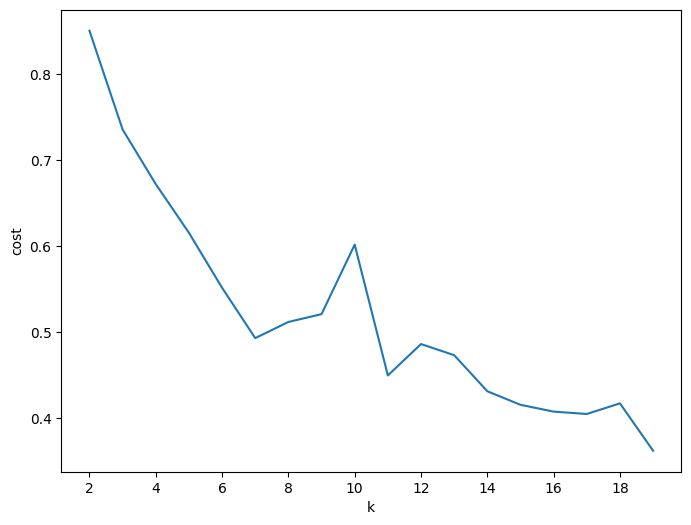

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, 20), cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


#### Pipeline

In [13]:
kmeans = KMeans() \
    .setK(3) \
    .setFeaturesCol("indexedFeatures")\
    .setPredictionCol("cluster")

pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(transformed)

cluster = model.transform(transformed)


In [14]:
cluster = model.transform(transformed)

In [15]:
cluster.show()

+-----------------+-----------------+-------+
|         features|  indexedFeatures|cluster|
+-----------------+-----------------+-------+
|[5.1,3.5,1.4,0.2]|[5.1,3.5,1.4,0.2]|      1|
|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|      1|
|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|      1|
|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|      1|
|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|      1|
|[5.4,3.9,1.7,0.4]|[5.4,3.9,1.7,0.4]|      1|
|[4.6,3.4,1.4,0.3]|[4.6,3.4,1.4,0.3]|      1|
|[5.0,3.4,1.5,0.2]|[5.0,3.4,1.5,0.2]|      1|
|[4.4,2.9,1.4,0.2]|[4.4,2.9,1.4,0.2]|      1|
|[4.9,3.1,1.5,0.1]|[4.9,3.1,1.5,0.1]|      1|
|[5.4,3.7,1.5,0.2]|[5.4,3.7,1.5,0.2]|      1|
|[4.8,3.4,1.6,0.2]|[4.8,3.4,1.6,0.2]|      1|
|[4.8,3.0,1.4,0.1]|[4.8,3.0,1.4,0.1]|      1|
|[4.3,3.0,1.1,0.1]|[4.3,3.0,1.1,0.1]|      1|
|[5.8,4.0,1.2,0.2]|[5.8,4.0,1.2,0.2]|      1|
|[5.7,4.4,1.5,0.4]|[5.7,4.4,1.5,0.4]|      1|
|[5.4,3.9,1.3,0.4]|[5.4,3.9,1.3,0.4]|      1|
|[5.1,3.5,1.4,0.3]|[5.1,3.5,1.4,0.3]|      1|
|[5.7,3.8,1.7,0.3]|[5.7,3.8,1.7,0.